In [396]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

MAZE_FILE_NAME = '../Maze_2.png'
ROBOT_FILE_NAME = '../Robot.png'
IMAGE_LADYBUG_FILE_NAME = '../Ladybug_small.png'
MAP_FILE_NAME = '../MapBuilt.txt'

def configureParams(minThreshold=0,
                    maxThreshold=255,
                    filterByArea=True,
                    minArea=0,
                    maxArea=100000,
                    filterByColor=True,
                    blobColour=0,
                    filterByCircularity=True,
                    minCircularity=0,
                    maxCircularity=1,
                    filterByConvexity=True,
                    minConvexity=0,
                    maxConvexity=1,
                    filterByInertia=True,
                    minInertiaRatio=0,
                    maxInertiaRatio=1):
    '''
    All parameters are true by default and detects black blobs by default.
    '''
    # Create params checklist.
    params = cv2.SimpleBlobDetector_Params()

    # Filters by threshold (how gray).
    params.minThreshold = minThreshold
    params.maxThreshold = maxThreshold

    # Filters by area.
    params.filterByArea = filterByArea
    params.minArea = minArea
    params.maxArea = maxArea

    # Filters by colour (0 for black, 1 for white).
    params.filterByColor = filterByColor
    params.blobColor = blobColour

    # Filter by roundness.
    params.filterByCircularity = filterByCircularity
    params.minCircularity = minCircularity
    params.maxCircularity = maxCircularity

    # Filter by convexity.
    params.filterByConvexity = filterByConvexity
    params.minConvexity = minConvexity
    params.maxConvexity = maxConvexity

    # Filter by inertia (elongation).
    params.filterByInertia = filterByInertia
    params.minInertiaRatio = minInertiaRatio
    params.maxInertiaRatio = maxInertiaRatio

    return params

def readImage():
    '''
    Reads the maze image and shows it.
    '''
    image = cv2.imread(MAZE_FILE_NAME, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def maskColour(image, lower, upper):
    '''
    Given a lower and upper bound for a HSV colour, returns a binary image that is white-focused.
    '''
    retrieved_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(retrieved_image, lower, upper)
    kernel = np.ones((9, 9), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    i = mask > 0
    retrieved_image = np.zeros_like(image, np.uint8)
    retrieved_image[i] = image[i]
    retrieved_image[retrieved_image != 0] = 255
    return retrieved_image

def markFeature(image, mask, colour):
    '''
    Mark the image with the features of the mask. Marking uses the simple blob detector and the
    given colour.
    '''
    params = configureParams(filterByArea=False,
                             filterByColor=False,
                             blobColour=1,
                             minCircularity=0.8,
                             filterByConvexity=False,
                             filterByInertia=False)
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(mask)
    retrieved_image = image
    retrieved_points = []
    for keypoint in keypoints:
        retrieved_points.append((np.int(keypoint.pt[0]), np.int(keypoint.pt[1])))
        size = np.int(keypoint.size / 2)
        cv2.circle(retrieved_image, retrieved_points[-1], size, colour, thickness=4)
    return retrieved_image, retrieved_points

def markCorners(image):
    '''
    Identify the corners of the maze.
    '''
    cyan = maskColour(image, (89, 50, 0), (91, 255, 255)) # HSV colours
    magenta = maskColour(image, (149, 100, 150), (151, 255, 255)) # HSV colours
    cyan_features = markFeature(image, cyan, (255, 0, 255)) # RGB colours
    magenta_features = markFeature(image, magenta, (0, 255, 255)) # RGB colours
    retrieved_image = cyan_features[0] | magenta_features[0]
    return retrieved_image, cyan_features[1], magenta_features[1]

def focus(image, origin, points):
    '''
    Focus the perspective of the map. The corners of the map are at the corners of the image, the
    view is orthogonal with the ground, the width to height ratio is 9:5, and the top-left corner
    has the CYAN marker.
    '''
    if len(points) != 4:
        raise ValueError('Invalid number of markers')
    width = 9 * 350
    height = 5 * 350
    output_points = np.float32([[0, 0], [0, height - 1], [width - 1, 0], [width - 1, height - 1]])
    input_points = np.float32(sorted(points, key=lambda k: (k[0], k[1])))
    transform_matrix = cv2.getPerspectiveTransform(input_points, output_points)
    retrieved_image = cv2.warpPerspective(image, transform_matrix, (width, height), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    return retrieved_image


def detectWalls():
    pass

def detectPose():
    pass

def generateMap():
    pass


In [ ]:
if __name__ == '__main__':
    '''
    Task 1
    '''
    image = readImage()
    plt.figure(figsize=(13,13))
    plt.imshow(image)

In [ ]:
if __name__ == '__main__':
    '''
    Task 2
    '''
    image = readImage()
    image, _, _ = markCorners(image)
    plt.figure(figsize=(13,13))
    plt.imshow(image)

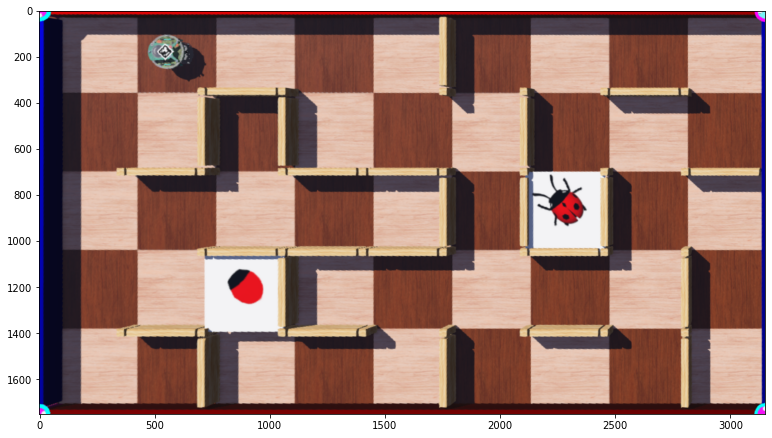

In [397]:
if __name__ == '__main__':
    '''
    Task 3
    '''
    image = readImage()
    image, origin, points = markCorners(image)
    image = focus(image, origin, points)
    plt.figure(figsize=(13,13))
    plt.imshow(image)